In [46]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import joblib
sns.set(style="whitegrid")

# Database credentials
DB_CONFIG = {
    'host': 'branchhomeworkdb.cv8nj4hg6yra.ap-south-1.rds.amazonaws.com',
    'port': 5432,
    'user': 'datascientist',
    'password': '47eyYBLT0laW5j9U24Uuy8gLcrN',
    'database': 'branchdsprojectgps'
}

# Connecting to the database with the credentials request and storing them in connection object
try:
    engine = create_engine(f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}")
    connection = engine.connect()
    print("Database connection established.")
except Exception as e:
    print(f"Error connecting to the database: {e}")


Exception during reset or similar
Traceback (most recent call last):
  File "C:\Users\aman tyagi\anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "C:\Users\aman tyagi\anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 988, in _reset
    pool._dialect.do_rollback(self)
  File "C:\Users\aman tyagi\anaconda3\lib\site-packages\sqlalchemy\engine\default.py", line 682, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.
server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.



Database connection established.


In [2]:
pip install psycopg2

Note: you may need to restart the kernel to use updated packages.


In [61]:
loan_outcomes = pd.read_sql("SELECT * FROM loan_outcomes", connection)
gps_fixes = pd.read_sql("SELECT * FROM gps_fixes", connection)
user_attributes = pd.read_sql("SELECT * FROM user_attributes", connection)
#Created 3 separate dataframes

# Displaying basic info for each DataFrame to understand data structure
print("Loan Outcomes:")
display(loan_outcomes.head())
print("GPS Fixes:")
display(gps_fixes.head())
print("User Attributes:")
display(user_attributes.head())

# Checking for null values and basic statistics
loan_outcomes.info()
gps_fixes.info()
user_attributes.info()


Loan Outcomes:


,user_id,application_at,loan_outcome
0,1,2017-08-14 09:08:50.000000,defaulted
1,2,2016-05-17 10:10:12.447976,repaid
2,3,2016-10-20 10:07:20.459081,defaulted
3,4,2017-01-13 13:03:34.000000,defaulted
4,5,2016-11-03 15:41:39.124610,repaid


GPS Fixes:


,gps_fix_at,server_upload_at,longitude,latitude,accuracy,altitude,bearing,location_provider,user_id
0,2017-06-22 09:37:20,2017-06-22 09:43:42,36.840540,-1.294342,68.4,0.0,0.0,fused,1
1,2017-08-14 07:50:27,2017-08-14 09:05:27,36.895270,-1.341928,1409.0,0.0,0.0,fused,1
2,2017-06-13 10:34:29,2017-06-13 10:54:48,36.811903,-1.307220,68.4,0.0,0.0,fused,1
3,2017-06-18 12:16:20,2017-06-18 12:16:24,36.907049,-1.309984,1581.0,0.0,0.0,fused,1
4,2017-06-28 09:39:08,2017-06-28 09:58:12,36.839396,-1.280310,1396.0,0.0,0.0,fused,1


User Attributes:


,user_id,age,cash_incoming_30days
0,1,42,8988.12
1,2,36,9968.12
2,3,27,59.04
3,4,38,2129.03
4,5,33,2102.53


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         400 non-null    int64         
 1   application_at  400 non-null    datetime64[ns]
 2   loan_outcome    400 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 9.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26710 entries, 0 to 26709
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   gps_fix_at         26710 non-null  datetime64[ns]
 1   server_upload_at   26710 non-null  datetime64[ns]
 2   longitude          26710 non-null  float64       
 3   latitude           26710 non-null  float64       
 4   accuracy           26710 non-null  float64       
 5   altitude           26710 non-null  float64       
 6   bearing       

In [36]:
# Looking at the location provider column and the count of different location providers. This could be useful in measuring the defaulter rate.
gps_df = pd.DataFrame(gps_features)
gps_df['location_provider'].value_counts()


0    330
2     29
1     13
Name: location_provider, dtype: int64

In [63]:
from sklearn.preprocessing import LabelEncoder

# Aggregate GPS data
gps_features = gps_fixes.groupby('user_id').agg({
    'accuracy': ['mean', 'max', 'min'],
    'altitude': ['mean', 'max', 'min'],
    'bearing': ['mean', 'max', 'min'],
    'latitude': ['mean'],
    'longitude': ['mean']
})

# Flattening column names after aggregation so that each user id can be mapped with an aggregated value in these statistical columns
gps_features.columns = ['_'.join(col) for col in gps_features.columns]
gps_features.reset_index(inplace=True)

# Getting the most frequent location_provider for each user based on mode and replacing it
most_frequent_location_provider = gps_fixes.groupby('user_id')['location_provider'].agg(lambda x: x.mode()[0])

# Merging the most frequent location provider with the GPS features
gps_features = gps_features.merge(most_frequent_location_provider, on='user_id', how='left')

# Performing label encoding for location_provider categorical column
# # NOTE : Tried to perform with One Hot Encoding but it reduced the accuracy. Could be due to dimensionality curse.
# # I would perform PCA and LDA further in the future and could help in further improving the accuracy
label_encoder = LabelEncoder()
gps_features['location_provider'] = label_encoder.fit_transform(gps_features['location_provider'])

# Display sample of the combined GPS features with label encoding for 'location_provider'
display(gps_features.head())


,user_id,accuracy_mean,accuracy_max,accuracy_min,altitude_mean,altitude_max,altitude_min,bearing_mean,bearing_max,bearing_min,latitude_mean,longitude_mean,location_provider
0,1,1105.084571,4434.00,5.4,75.690000,1730.80,0.0,8.214286,276.00,0.00,-1.270427,36.782813,0
1,2,48.596000,310.59,12.0,1030.603000,1761.47,-23.0,18.860000,184.60,-1.00,-1.488055,37.118432,0
2,3,6.500000,6.50,6.5,2190.900000,2190.90,2190.9,273.620000,273.62,273.62,-0.889673,35.707550,1
3,4,2172.200000,4292.00,52.4,0.000000,0.00,0.0,0.000000,0.00,0.00,-0.306798,36.082255,0
4,5,43.461111,96.00,20.0,542.622222,1663.84,0.0,50.248889,302.12,0.00,17.800041,-12.370879,0


In [64]:
# Merging all features into one DataFrame
data = loan_outcomes.merge(user_attributes, on="user_id", how="left").merge(gps_features, on="user_id", how="left")

data.dropna(inplace=True)

# Label Encoding target variable (1 for repaid, 0 for defaulted)
data['loan_outcome'] = data['loan_outcome'].apply(lambda x: 1 if x == 'repaid' else 0)
display(data.head())


,user_id,application_at,loan_outcome,age,cash_incoming_30days,accuracy_mean,accuracy_max,accuracy_min,altitude_mean,altitude_max,altitude_min,bearing_mean,bearing_max,bearing_min,latitude_mean,longitude_mean,location_provider
0,1,2017-08-14 09:08:50.000000,0,42,8988.12,1105.084571,4434.00,5.4,75.690000,1730.80,0.0,8.214286,276.00,0.00,-1.270427,36.782813,0.0
1,2,2016-05-17 10:10:12.447976,1,36,9968.12,48.596000,310.59,12.0,1030.603000,1761.47,-23.0,18.860000,184.60,-1.00,-1.488055,37.118432,0.0
2,3,2016-10-20 10:07:20.459081,0,27,59.04,6.500000,6.50,6.5,2190.900000,2190.90,2190.9,273.620000,273.62,273.62,-0.889673,35.707550,1.0
3,4,2017-01-13 13:03:34.000000,0,38,2129.03,2172.200000,4292.00,52.4,0.000000,0.00,0.0,0.000000,0.00,0.00,-0.306798,36.082255,0.0
4,5,2016-11-03 15:41:39.124610,1,33,2102.53,43.461111,96.00,20.0,542.622222,1663.84,0.0,50.248889,302.12,0.00,17.800041,-12.370879,0.0


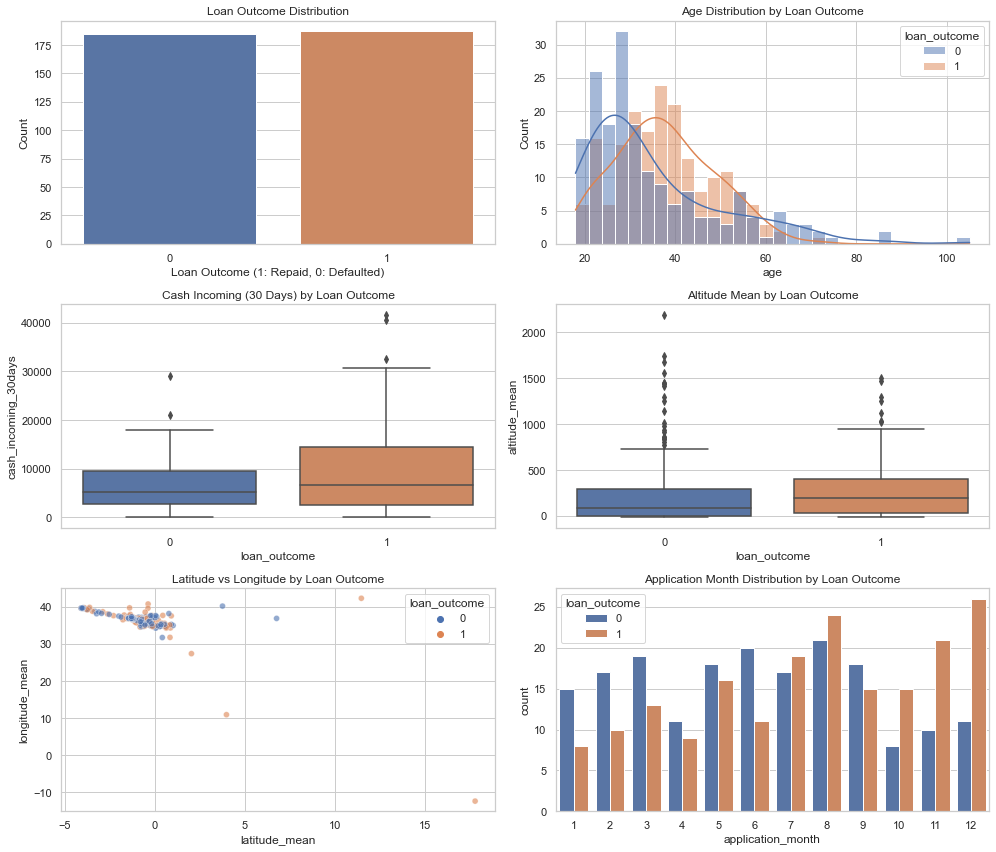

In [67]:
plt.figure(figsize=(14, 12))

# Distribution of the target variable (loan outcome)
plt.subplot(3, 2, 1)
sns.countplot(x='loan_outcome', data=data)
plt.title('Loan Outcome Distribution')
plt.xlabel('Loan Outcome (1: Repaid, 0: Defaulted)')
plt.ylabel('Count')

# Age distribution by loan outcome
plt.subplot(3, 2, 2)
sns.histplot(data=data, x='age', hue='loan_outcome', kde=True, bins=30)
plt.title('Age Distribution by Loan Outcome')

# Cash incoming 30 days by loan outcome
plt.subplot(3, 2, 3)
sns.boxplot(x='loan_outcome', y='cash_incoming_30days', data=data)
plt.title('Cash Incoming (30 Days) by Loan Outcome')

# Altitude mean distribution by loan outcome
plt.subplot(3, 2, 4)
sns.boxplot(x='loan_outcome', y='altitude_mean', data=data)
plt.title('Altitude Mean by Loan Outcome')

# Scatter plot of Latitude vs. Longitude (could help identify regional patterns)
plt.subplot(3, 2, 5)
sns.scatterplot(x='latitude_mean', y='longitude_mean', hue='loan_outcome', data=data, alpha=0.6)
plt.title('Latitude vs Longitude by Loan Outcome')

# Application month and day with respect to loan outcome
plt.subplot(3, 2, 6)
sns.countplot(x='application_month', hue='loan_outcome', data=data)
plt.title('Application Month Distribution by Loan Outcome')

plt.tight_layout()
plt.show()


In [ ]:
# The dataset is balanced with equal number of 0's and 1's in the loan defaulter

In [ ]:
# Most of the people who were defaulters were of age<40

In [ ]:
# Cash incoming in 30 days was less for defaulters than non defaulters, same goes for altitude mean
# In the initial months defaulters were more and after 7th month people who repaid were more than defaulters
# The coordinates of most of the people come from the same general location except for a few outliers that are present in the data 

C:\Users\aman tyagi\AppData\Local\Temp\ipykernel_22464\2558864591.py:21: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


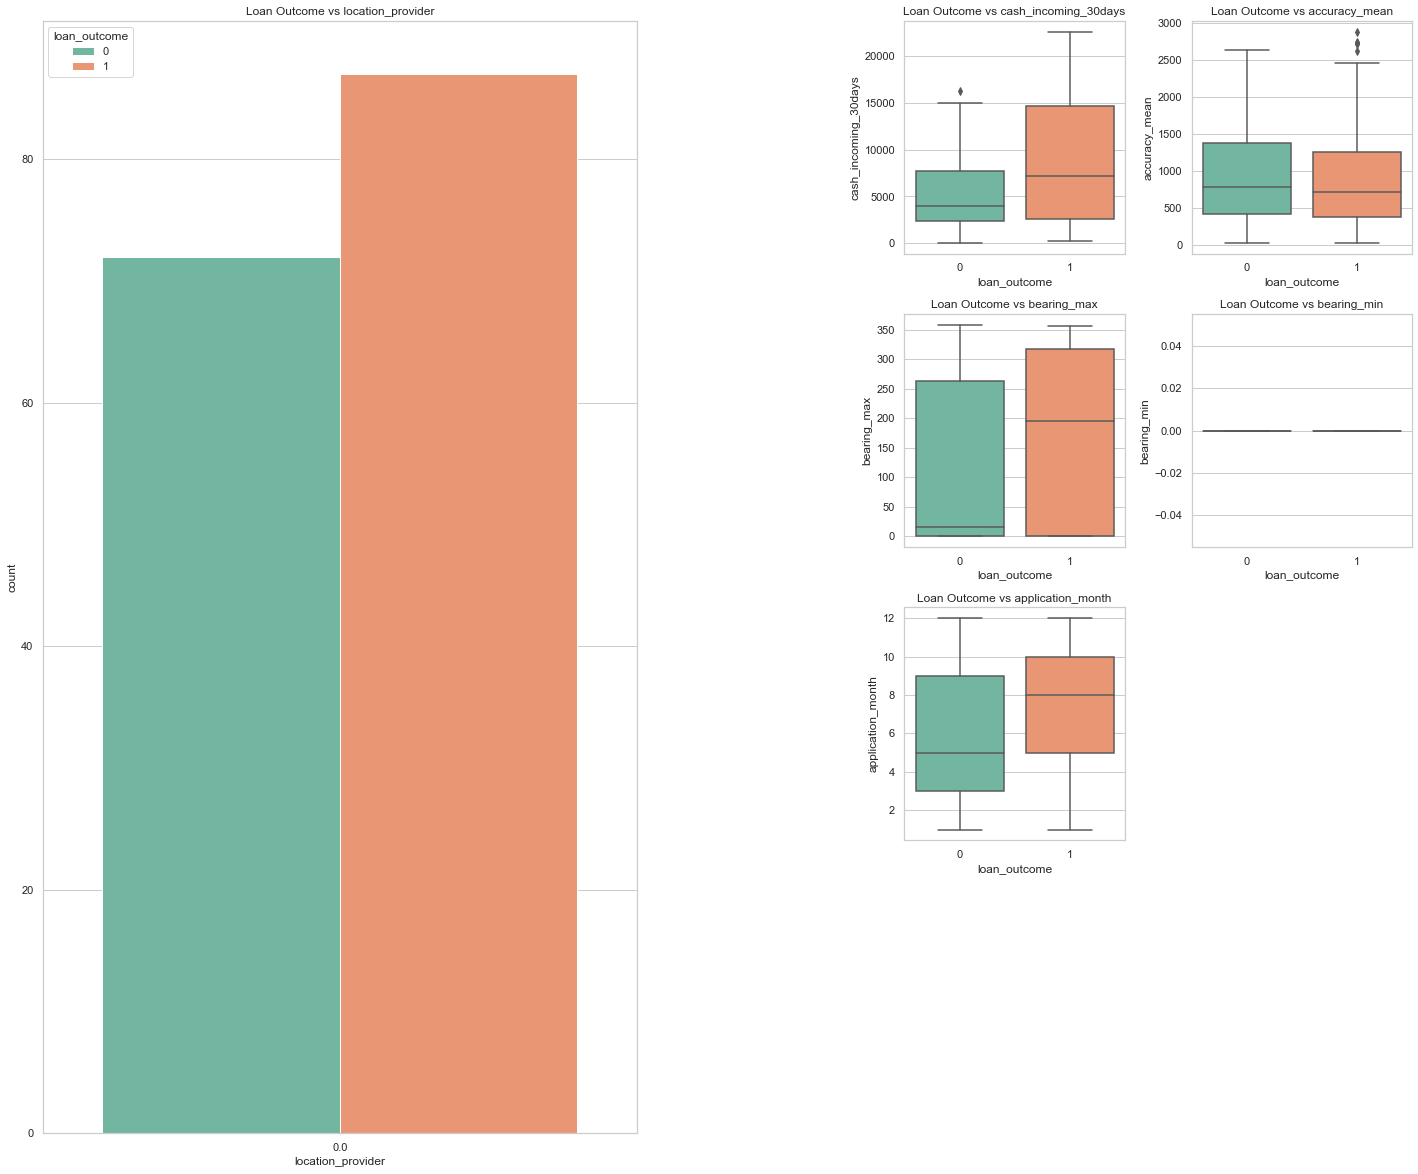

In [83]:

plt.figure(figsize=(20, 16))

# List of columns to visualize
continuous_cols = list(data.columns)

# Categorical columns
categorical_cols = ['location_provider']

# Plotting continuous features vs loan outcome (Boxplots)
for i, col in enumerate(continuous_cols):
    plt.subplot(4, 5, i + 1)
    sns.boxplot(x='loan_outcome', y=col, data=data, palette='Set2')
    plt.title(f'Loan Outcome vs {col}')
    plt.tight_layout()

# Plotting categorical features vs loan outcome (Bar plots)
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 2, i + 1)
    sns.countplot(x=col, hue='loan_outcome', data=data, palette='Set2')
    plt.title(f'Loan Outcome vs {col}')
    plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
#The loan outcome differs for different network providers
#The boxplots suggest that the same as previously, and accuracy mean for defaulters is more for people above the 50 quantile range
# Bearing max is more for most people who are not defaulters above the 50th quantile and application month still suggests the same thing as before

In [66]:
if 'application_at' in data.columns:
    # Example: extract components or calculate days since a reference date
    data['application_day'] = data['application_at'].dt.day
    data['application_month'] = data['application_at'].dt.month
    data['application_year'] = data['application_at'].dt.year
    # Drop original datetime column
    data = data.drop(columns=['application_at'])

<AxesSubplot:>

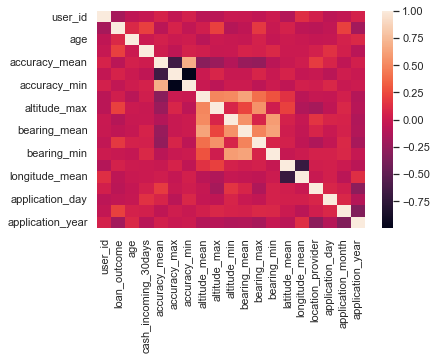

In [68]:
df = pd.DataFrame(data)
sns.heatmap(df.corr()) # Creating a heatmap to visualize the correlations better

In [ ]:
# Almost all the independent feateures are uncorellated with each other

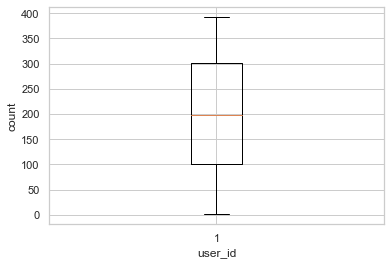

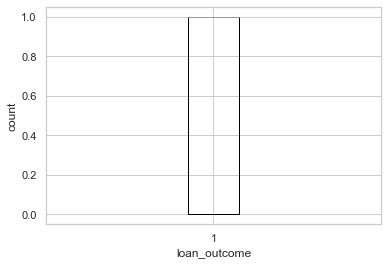

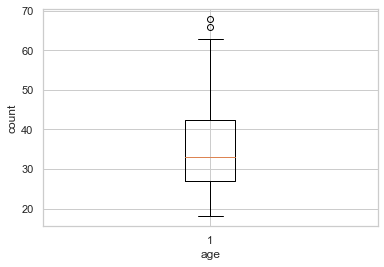

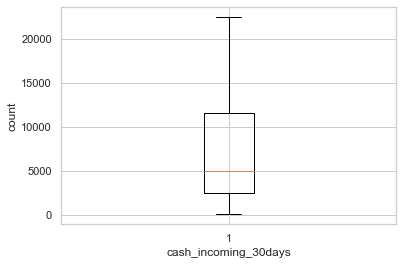

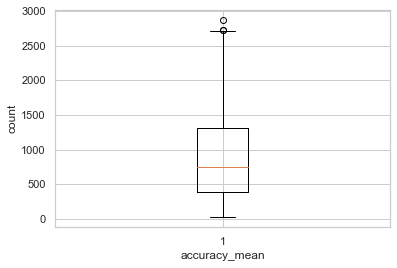

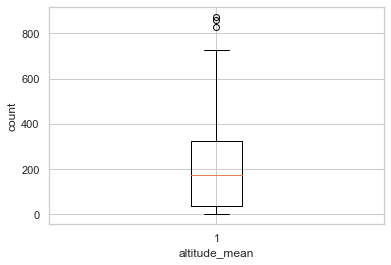

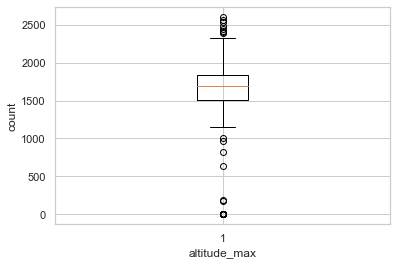

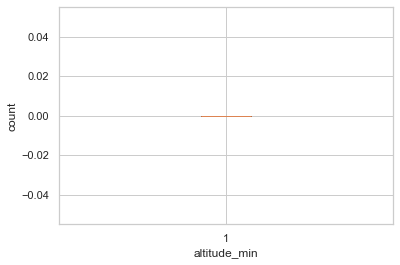

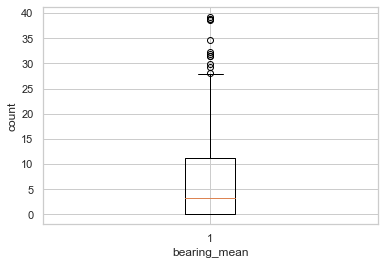

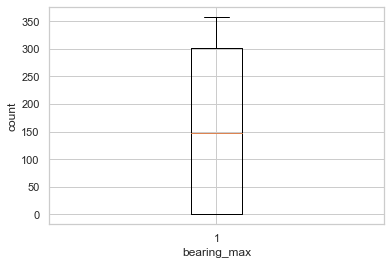

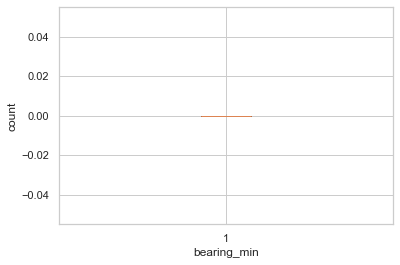

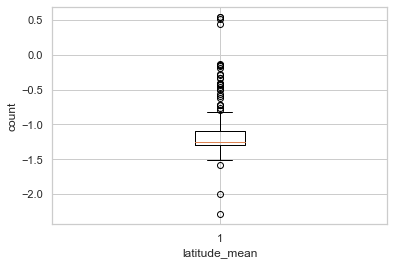

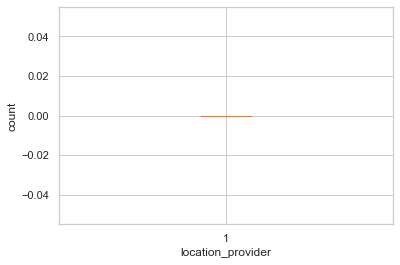

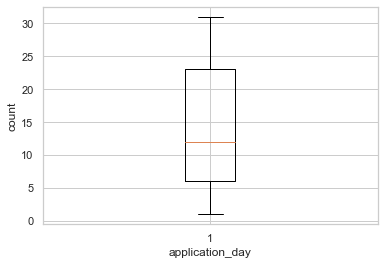

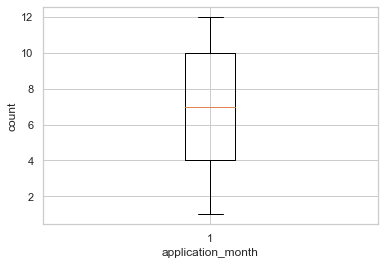

In [29]:
col_names = df.columns

for col_name in col_names:
    if(df[col_name].dtypes=='int64' or df[col_name].dtypes=='float64'):
        plt.boxplot(df[col_name])
        plt.xlabel(col_name)
        plt.ylabel('count')
        plt.show()

In [69]:
# IQR(Inter Quantile Range) Method for removing outliers that are 1.5 times above or below the 75 qualite and 25 quantile respectively
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)] # axis = 1 --> column wise
print(df.shape)

(159, 19)


In [71]:
df = df.drop(columns=['accuracy_max','accuracy_min','longitude_mean','application_year'], axis=1)


In [70]:
col_list = []
for col in df.columns:
    if ((df[col].dtype != 'object') & (col != 'loan_outcome') ):
        col_list.append(col)

print(col_list) #Independent features list 
# # NOTE : Checking one last time the independent features should not have any major correlations with each other as it brings in the 
# # problem of multicollinearity which raises problems in traning multiple regression models

X = df[col_list]

from statsmodels.stats.outliers_influence import variance_inflation_factor


vif_data = pd.DataFrame() # Creating a new data frame
vif_data["feature"] = X.columns # adding a column- feature which will contain all the column names
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

df = df.drop(columns=['accuracy_max','accuracy_min','longitude_mean','application_year','altitude_max'], axis=1)
col_list = []
for col in df.columns:
    if ((df[col].dtype != 'object') & (col != 'loan_outcome') ):
        col_list.append(col)

print(col_list)
X = df[col_list]


vif_data = pd.DataFrame() # Creating a new data frame
vif_data["feature"] = X.columns # adding a column- feature which will contain all the column names
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

['user_id', 'age', 'cash_incoming_30days', 'accuracy_mean', 'accuracy_max', 'accuracy_min', 'altitude_mean', 'altitude_max', 'altitude_min', 'bearing_mean', 'bearing_max', 'bearing_min', 'latitude_mean', 'longitude_mean', 'location_provider', 'application_day', 'application_month', 'application_year']
                 feature           VIF
0                user_id      4.533938
1                    age     10.493236
2   cash_incoming_30days      2.919904
3          accuracy_mean      5.258078
4           accuracy_max     11.965911
5           accuracy_min      8.563111
6          altitude_mean      4.211986
7           altitude_max     13.186738
8           altitude_min           NaN
9           bearing_mean      3.747627
10           bearing_max      6.362303
11           bearing_min           NaN
12         latitude_mean     14.344303
13        longitude_mean  10817.513375
14     location_provider           NaN
15       application_day      3.631152
16     application_month      5.01

C:\Users\aman tyagi\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\aman tyagi\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


In [71]:
data = df

# Define features and target
X = data.drop(columns=['user_id', 'loan_outcome'], axis=1)
y = data['loan_outcome']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [72]:
X_train,y_train

(array([[ 0.62154894,  0.36442424,  0.61919793, ...,  0.        ,
         -0.63451664, -1.11050719],
        [ 0.53354814, -0.5530279 , -0.97583988, ...,  0.        ,
         -0.52649571,  0.29702188],
        [-1.22646781,  0.95075815, -1.13032937, ...,  0.        ,
          0.12162986,  1.42304515],
        ...,
        [-0.25845904,  0.77148033, -1.23861046, ...,  0.        ,
         -0.20243292,  0.5785277 ],
        [-0.34645983,  0.17805593, -0.54385521, ...,  0.        ,
          1.52590194, -0.54749556],
        [-0.34645983,  0.58377898, -1.05357856, ...,  0.        ,
         -1.06660035, -1.11050719]]),
 188    1
 352    0
 14     1
 218    0
 119    1
       ..
 184    0
 271    1
 38     1
 228    1
 261    0
 Name: loan_outcome, Length: 127, dtype: int64)

Classifier: Logistic Regression
Accuracy: 0.78125
ROC AUC: 0.753968253968254
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.64      0.72        14
           1       0.76      0.89      0.82        18

    accuracy                           0.78        32
   macro avg       0.79      0.77      0.77        32
weighted avg       0.79      0.78      0.78        32


--------------------------------------------------

Classifier: Random Forest
Accuracy: 0.6875
ROC AUC: 0.7123015873015873
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.43      0.55        14
           1       0.67      0.89      0.76        18

    accuracy                           0.69        32
   macro avg       0.71      0.66      0.65        32
weighted avg       0.70      0.69      0.67        32


--------------------------------------------------

Classifier: SVM
Accuracy: 0.59375
ROC AUC: 0.6

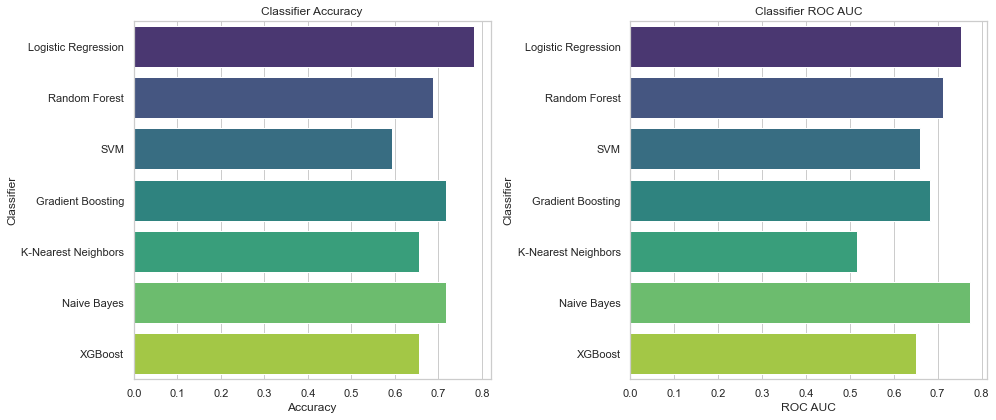

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import pandas as pd

# Convert X and y to DataFrames and perform stratified split
X = pd.DataFrame(data.drop(columns=['user_id', 'loan_outcome']))
y = pd.DataFrame(data['loan_outcome'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Squeeze y_train and y_test to series for compatibility with classifiers
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Define classifiers to test, including XGBoost
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and evaluate each classifier
results = {}
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
    
    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"
    
    # Save results
    results[name] = {
        "Accuracy": accuracy,
        "ROC AUC": roc_auc,
        "Classification Report": classification_report(y_test, y_pred)
    }

# Print the results for each classifier
for name, metrics in results.items():
    print(f"Classifier: {name}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"ROC AUC: {metrics['ROC AUC']}")
    print("Classification Report:")
    print(metrics["Classification Report"])
    print("\n" + "-"*50 + "\n")

# Plotting the results for Accuracy and ROC AUC

metrics_df = pd.DataFrame({
    'Classifier': list(results.keys()),
    'Accuracy': [metrics['Accuracy'] for metrics in results.values()],
    'ROC AUC': [metrics['ROC AUC'] for metrics in results.values()]
})

plt.figure(figsize=(14, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
sns.barplot(x='Accuracy', y='Classifier', data=metrics_df, palette='viridis')
plt.title('Classifier Accuracy')

# ROC AUC plot
plt.subplot(1, 2, 2)
sns.barplot(x='ROC AUC', y='Classifier', data=metrics_df, palette='viridis')
plt.title('Classifier ROC AUC')

plt.tight_layout()
plt.show()


In [ ]:
# Best accuracy improved from 0.62 to 0.78 for Logistic Regression.

In [88]:
import joblib

log_reg_model = classifiers['Logistic Regression']

# Saving the trained Logistic Regression model and scaler
joblib.dump(log_reg_model, 'loan_prediction_log_reg_model.pkl')
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler as well


['scaler.pkl']

In [10]:
!pip install xgboost



ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\aman tyagi\\anaconda3\\Lib\\site-packages\\~-mpy.libs\\libopenblas64__v0.3.23-293-gc2f4bdbb-gcc_10_3_0-2bde3a66a51006b2b53eb373ff767a3f.dll'
Consider using the `--user` option or check the permissions.



  Using cached numpy-1.22.4-cp39-cp39-win_amd64.whl (14.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


In [ ]:

from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np

# Load the trained model
model = joblib.load('logistic_model.pkl')

# Initialize Flask app
app = Flask(__name__)

# Sample function to process user input (this would vary depending on the input format)
def process_input(user_data):
    # Assuming user_data is a dictionary containing feature values
    # Convert it to a pandas DataFrame or numpy array as required by the model
    user_data_df = pd.DataFrame([user_data])  # Ensure data is in correct format
    return user_data_df

# Define the API endpoint to get prediction
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get data from POST request (raw JSON or form data)
        data = request.get_json()  # Assuming data is sent in JSON format
        
        # Process input data (if necessary)
        user_data = process_input(data)
        
        # Make prediction using the trained model
        prediction = model.predict(user_data)
        
        # Prepare the response as JSON
        response = {
            'loan_outcome': 'repaid' if prediction[0] == 1 else 'defaulted',
            'prediction': int(prediction[0])  # 1 = repaid, 0 = defaulted
        }
        
        return jsonify(response)
    except Exception as e:
        return jsonify({'error': str(e)}), 400

# Run the app
if __name__ == '__main__':
    app.run(debug=True)


In [84]:
!pip install flask


In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np

model = joblib.load('loan_prediction_log_reg_model.pkl')
scaler = joblib.load('scaler.pkl')

app = Flask(__name__)

# Function to preprocess input data (scale features and convert to correct format)
def preprocess_input(user_data):
    # Convert the input data (user features) to a pandas DataFrame
    user_data_df = pd.DataFrame([user_data])  # Convert to DataFrame for consistency
    # Scale the features using the saved scaler
    user_data_scaled = scaler.transform(user_data_df)
    return user_data_scaled

# Defining the API endpoint for prediction
@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json()
        
        user_id = data.get('user_id')
        raw_data = data.get('raw_data')

        if not user_id and not raw_data:
            return jsonify({'error': 'Please provide either user_id or raw_data.'}), 400
        
        if user_id:
            user_data = get_user_data_from_db(user_id)
            if not user_data:
                return jsonify({'error': 'User data not found in database'}), 404
        elif raw_data:
            user_data = raw_data
        
        user_data_scaled = preprocess_input(user_data)
        
        # Make the prediction using the model
        prediction = model.predict(user_data_scaled)
        
        # Prepare the response based on the prediction
        prediction_result = 'repaid' if prediction[0] == 1 else 'defaulted'
        
        response = {
            'loan_outcome': prediction_result,
            'prediction': int(prediction[0])  # 1 = repaid, 0 = defaulted
        }

        return jsonify(response)
    
    except Exception as e:
        return jsonify({'error': str(e)}), 400

def get_user_data_from_db(user_id):
    # Example, you would replace this with actual database querying code
    # Assume the data is returned as a dictionary or pandas DataFrame
    sample_data = {
        'age': 30,
        'cash_incoming_30days': 5000,
        'accuracy_mean': 25.0,
        'latitude_mean': -1.2920,
        'longitude_mean': 36.8210,
        # Will add all features in the future while deployment
    }
    return sample_data

# Run the app
if __name__ == '__main__':
    app.run(debug=True)


In [ ]:
## FUTURE RECOMMENDATIONS WITH LARGE DATASET #
# Data Preprocessing: Imputation, outlier removal, encoding, scaling.
#1. Exploratory Data Analysis (EDA): Visualizations, correlations, and dimensionality reduction

#2. Model Selection: Logistic Regression, Random Forests, XGBoost, SVM, etc.

#3. Hyperparameter Tuning: GridSearchCV or RandomizedSearchCV.

#4. Handling Imbalanced Data: SMOTE, class balancing, ensemble methods.

#5. Model Interpretation: SHAP, LIME, and feature importance.

#6. Model Deployment: Flask or FastAPI for exposing the model as an API.

#7. Continuous Monitoring and Retraining: Track model performance and retrain as necessary.

#8. Performance Optimization: Use parallelism, batch processing, and model compression.

#9. Time series for better monitoring of defaulters over a period of time which I did not employ currently along with the gps integrations from the Android API

#10. Using CNNS and other Deep learning models for catching and learning complexity.